# Изучение работы методов контроля температуры в молекулярной динамике

Построим файл топологии для молекулы этана

In [37]:
# загрузим модули
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from IPython.display import Image,display
import numpy as np
import os

RDKit WARNING: [00:07:14] Enabling RDKit 2019.09.3 jupyter extensions


Используем потенциал 3 для торсионных углов, типы атомов opls_139 и opls_140 для атомов углерода и водорода ссответственно. Достроим файл: добавим все углы и двугранные углы.

In [38]:
top = '''
#include "/usr/share/gromacs/top/oplsaa.ff/forcefield.itp"

[ moleculetype ]
; Name            nrexcl
et            3

[ atoms ]
;   nr  type  resnr  residue  atom   cgnr     charge       mass
    1   opls_139      1    ETH      C1      1    -0.189      12.01
    2   opls_139      1    ETH      C2      2    -0.155      12.01
    3   opls_140      1    ETH      H1      3     0.0059       1.008
    4   opls_140      1    ETH      H2      4     0.0059       1.008
    5   opls_140      1    ETH      H3      5     0.0059       1.008
    6   opls_140      1    ETH      H4      6     0.0056       1.008
    7   opls_140      1    ETH      H5      7     0.0056       1.008
    8   opls_140      1    ETH      H6      8     0.0056       1.008
    
[ bonds ]
;  ai    aj funct  b0       kb
     1   2   1  
     1   3   1
     1   4   1  
     1   5   1  
     2   6   1
     2   7   1
     2   8   1

[ angles ]
;  ai    aj    ak funct  phi0   kphi
;around c1
    3     1     4     1  
    4     1     5     1  
    3     1     5     1  
    2     1     3     1  
    2     1     4     1  
    2     1     5     1  
;around c2
    6     2     8     1  
    7     2     8     1  
    6     2     7     1  
    1     2     6     1  
    1     2     7     1  
    1     2     8     1 

[ dihedrals ]
;  ai    aj    ak    al funct  
    3    1     2     6      3  
    3    1     2     7      3 
    3    1     2     8      3  
    4    1     2     6      3  
    4    1     2     7      3 
    4    1     2     8      3
    5    1     2     6      3  
    5    1     2     7      3 
    5    1     2     8      3
 
[ pairs ]
; список атомов 1-4
;  ai    aj funct
   3  6
   3  7
   3  8
   4  6
   4  7
   4  8
   5  6
   5  7
   5  8

[ System ]
; any text here
first one
[ molecules ]
;Name count
 et    1
'''
with open('eth.top', 'w') as f:
    f.write(top)

Использованы следующие методы контроля температуры:

be - метод Берендсена для контроля температуры.

vr - метод "Velocity rescale" для контроля температуры.

nh - метод Нуза-Хувера для контроля температуры.

an - метод Андерсена для контроля температуры.

sd - метод стохастической молекулярной динамики.

In [39]:
methods = ['be', 'vr', 'nh', 'an', 'sd']

for m in methods:
    os.system('wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/{0}.mdp'.format(m))

Построим систему для симуляции МД и запустим GROMACS:

In [40]:
for m in methods:
    os.system('grompp -f {0}.mdp -c et.gro -p et.top -o et_{0}.tpr'.format(m))
    os.system('mdrun -deffnm et_{0} -v -nt 1'.format(m))

Построим анимацию (pdb) молекулярной динамики, извлечем потенциальную и кинетическую энергию для шагов симуляции с каждым методом контроля.

In [41]:
for m in methods:
    os.system('echo 2 | trjconv -f et_{0}.trr -s et_{0}.tpr -o et_{0}.pdb'.format(m))
    os.system('echo "10 11 \n \n" |g_energy -f et_{0}.edr -o et_{0}_en.xvg -xvg none'.format(m))

Построим зависимость потенциальной и кинетической энергии от времени:

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#t = {}
kin = {}
pot = {}
for m in methods:
    a= np.loadtxt('et_%s_en.xvg' % m)
    t=a[:,0]
    pot[m]=a[:,1]
    kin[m] =a[:,2] 

In [43]:
methods_s = sorted(methods, key = lambda x : np.std(kin[x]), reverse = True)

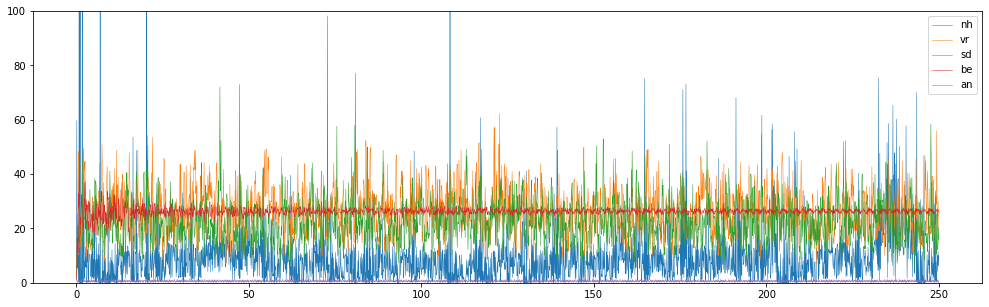

In [44]:
plt.set_cmap('Accent')
for n, m in enumerate(methods_s):
    plt.plot(t, pot[m],  linewidth=0.5, label=m)
plt.legend(methods_s)
plt.ylim(0, 100)
plt.show()

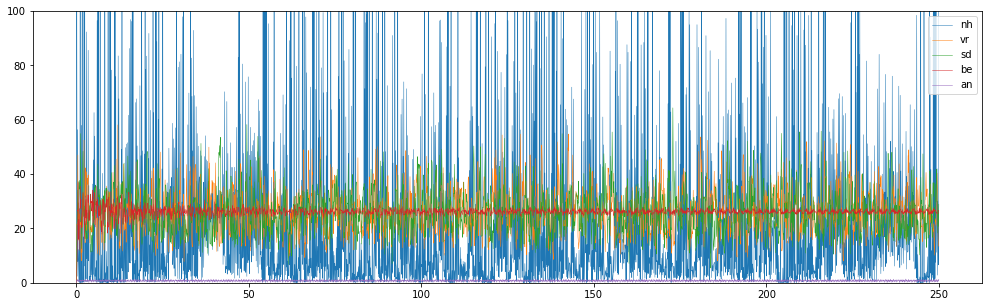

In [45]:
plt.set_cmap('Accent')
for n, m in enumerate(methods_s):
    plt.plot(t, kin[m], linewidth=0.5)
plt.legend(methods_s)
plt.ylim(0, 100)
plt.show()

In [46]:
np.mean(pot['an'])

0.6242371399440224

In [47]:
for m in methods:
    os.system('g_bond -f et_{0}.trr -s et_{0}.tpr -o bond_{0}.xvg -n b.ndx -xvg none'.format(m))    

Получим время (real) расчета GROMACS для этих алгоритмов контроля:

In [49]:
for m in methods:
    with open("et_%s.log" % m) as f:
        print(m, f.readlines()[-4].split()[2])

be 4.082
vr 4.192
nh 4.179
an 4.018
sd 4.673


В рассмотренной системе производительность методов контроля температуры практически не отличается. Методы выдают разные результаты для распределений состояний системы во времени по кинетической\потенциальной энергии и по длине C-C связи, различие этих результатов легко описать как различие дисперсии распределения.

Метод Андерсена выдает некорректные (в ~50 меньше прочих методов) значения энергии системы.

Методы Нуза-Хувера и Берендсена дают сильно отличающиеся от прочих методов значения дисперсии: это объясняется тем, что эти методы не предназначены для описания систем с малым числом степеней свободы.

Методы стохастической молекулярной динамики и velocity rescale дают близкие значения распределений, средние среди прочих методов: вероятно, для рассматриваемой системы стоит использовать один из них: мне показалось, что результат симуляции velocity rescale ближе к ожидаемому движению молекулы этана.